# Data 607 Final Project - Luke Bramfield

#### **Purpose of the project**
The domain of this project is banking marketing. I want to investigate what combination of features at what levels lead to a client accepting a term deposit offered via a marketing campaign. In addition, I also want to perform customer segmentation analysis. The practical implications of this analysis are discovering what works in obtaining the desired outcome (eg. sale of a term deposit) and for who? This is highly relevant as it can help a financial institution decide how they can construct their marketing campaigns and where they should focus their efforts. The population of interest in this dataset are clients of a Portuguese banking institution.

#### **The Data**

The dataset used is coming from an open source repository from Hugging Face at https://huggingface.co/datasets/Andyrasika/banking-marketing. 
However, the data was originally collected as part of a research paper conducted by Sérgio Moro, Raul M. S. Laureano, and Paulo Cortez titled "Using Data Mining for Bank Direct Marketing:An Application of the Crisp-dm Methodology". The data spans from May of 2008 to November of 2010 and was related to a total of 17 telephone marketing campaigns and 79,354 customer contacts (Moro et al., n.d.). In the course of these telephone campaigns, customers were presented with an appealing long-term deposit offer featuring competitive interest rates (Moro et al., n.d.). For every interaction, a comprehensive set of attributes was recorded. Let's read in the data sets and get a quick understanding of the variables, and their distributions. 

In [648]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from lukes_funcs import open_pdf,close_pdf

In [649]:
training_data = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\train_banking_marketing.parquet")
testing_data = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\test-banking_marketing.parquet")

print(f"The training data consists of {len(training_data)} rows and the testing set consists of {len(testing_data)} rows")

The training data consists of 45211 rows and the testing set consists of 4521 rows


In [650]:
variables = training_data.columns
variables_string = ', '.join(variables)
print(f"""There are a total of {len(variables)} variables in the dataset and they are labeled as follows: 
{variables_string}""")

There are a total of 17 variables in the dataset and they are labeled as follows: 
age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, y


Here is the description of these variables copied straight from the Hugging Face documentation:


    1 - age (numeric)
    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")
    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
    4 - education (categorical: "unknown","secondary","primary","tertiary")
    5 - default: has credit in default? (binary: "yes","no")
    6 - balance: average yearly balance, in euros (numeric)
    7 - housing: has housing loan? (binary: "yes","no")
    8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:

    9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
    10 - day: last contact day of the month (numeric)
    11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
    12 - duration: last contact duration, in seconds (numeric)

other attributes:

    13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
    15 - previous: number of contacts performed before this campaign and for this client (numeric)
    16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

    17 - y - has the client subscribed a term deposit? (binary: "yes","no")


Let's get a sense of the distributions of these variables by plotting histograms

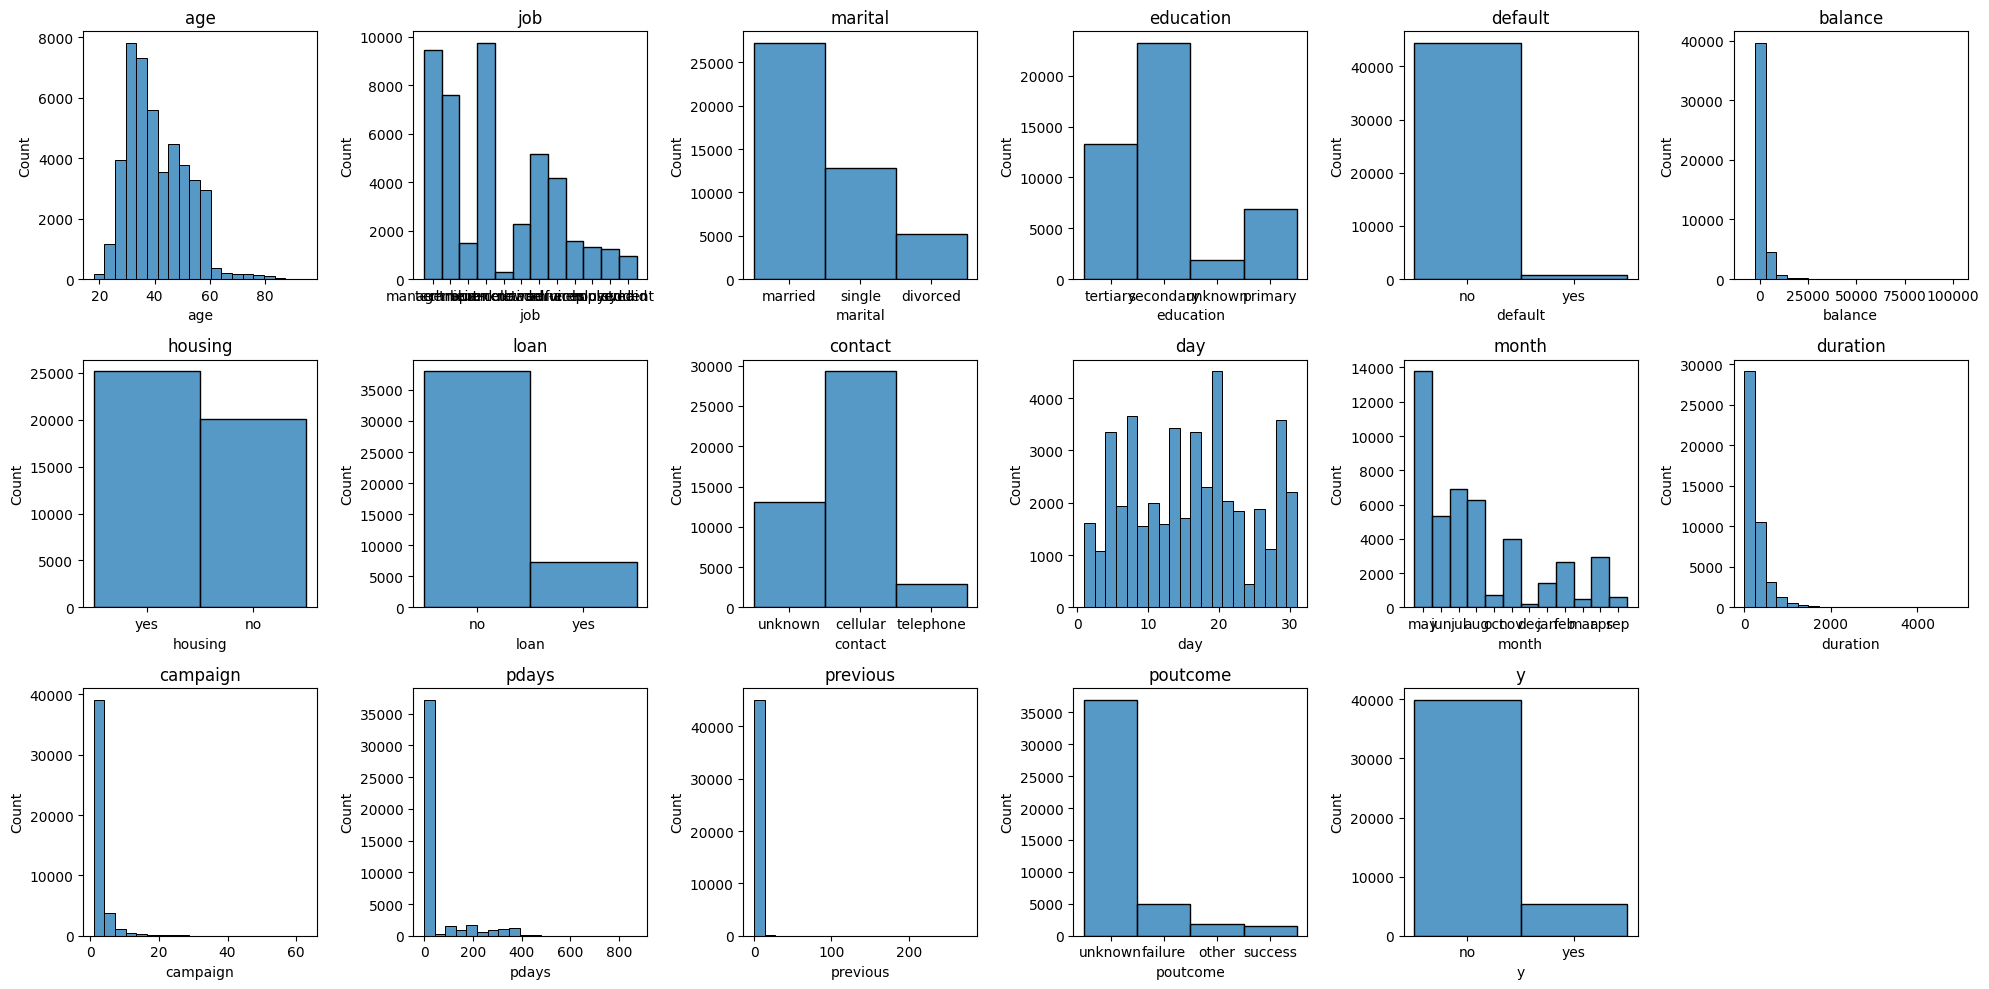

In [651]:
import seaborn as sns
fig, axes = plt.subplots(3,6,figsize = (20,10))
axes = axes.flatten()
for i,col in enumerate(training_data):
        axes[i].set_title(col)
        sns.histplot(data=training_data, x=col, ax=axes[i], fill=True,bins = 20)
    
plt.tight_layout()
axes[-1].set_visible(False)
plt.show()

We can quickly observe most of the numeric variables in the data set are heavily skewed to the right. This indicates we will have to apply some transformations and scaling for our machine learning algorithms. Also notice the class imbalances that exist among some of the categorical features.      

#### **Statistical Methodology**

The aim of the statistical analysis will have three main objectives:

1) To find an optimal classification model to be able to accurately predict whether a client will accept the term deposit offer or not. This will include experimenting with Support Vector Machines, KNN, Logistic Regression (Normalized Logistic Regression), Decision Tree Classifiers (including bagging and boosting), and bayesian classifiers (LDA, QDA, and Naive Bayes).

2) Define distinct customer segments in the dataset using descriptive statistics and unsupervised clustering algorithms such as K means.

3) Conclude with a summary of findings for the model with the best predictive power, determine what factors appear to bind customers into a certain segment and lastly provide insight into what groups of customers with what features should be targeted to increase the odds of running a successful marketing campaign.

This is highly applicable to the real world as it could help an institution refine the types of offerings it presents to it's clients and help with the banks operational planning and budgeting by answering questions such as:

If we roll out this campaign - based off our models and analysis how much revenue can we expect to generate? What clients should we prioritize?
How should we approach this client from this segment if we are to have a telephone conversation with them? and so forth. 

While the data is quite dated, I think it still has relevance for banking today. Telephone marketing has been around a long time and continues to persist. Moreover, while banks adapt and refine their products and strategies, I believe that peoples attitude towards telemarketing today likely remains very similar to that of roughly over a decade ago. However, this is just my opinion. Regardless, The data served very well for this kind of analysis and as an application of machine learning. 



In [3]:
# hot encode months or change them into 4 seasons 
# changing p days into binary variable 

def load_raw_data():

    from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split

    training_data = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\train_banking_marketing.parquet")
    testing_data = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\test-banking_marketing.parquet")

    features_tr = training_data.drop(columns = ["y"])
    features_te = testing_data.drop(columns = ["y"])
    features_tr['pdays'] = np.where(features_tr['pdays'] == -1, "no", "yes")
    features_te['pdays'] = np.where(features_te['pdays'] == -1, "no", "yes")


    hot_encoder = OneHotEncoder(sparse_output = False).set_output(transform="pandas")
    ord_encoder = OrdinalEncoder().set_output(transform = "pandas")

    bin_cat_tr = features_tr[["default","housing","loan","pdays"]]
    multi_cat_tr = features_tr[["job","marital","education","contact","poutcome","month"]]

    multi_cat_encoded_tr = hot_encoder.fit_transform(multi_cat_tr)
    bin_cat_encoded_tr = ord_encoder.fit_transform(bin_cat_tr)
    numeric_tr = features_tr[["age","balance","duration","campaign","previous"]]

    x_tr = pd.concat([bin_cat_encoded_tr,multi_cat_encoded_tr,numeric_tr],axis = 1)
    y_tr = np.where(training_data["y"] == "yes", 1,0)
    
    bin_cat_te = features_te[["default","housing","loan","pdays"]]
    multi_cat_te = features_te[["job","marital","education","contact","poutcome","month"]]

    multi_cat_encoded_te = hot_encoder.transform(multi_cat_te)
    bin_cat_encoded_te = ord_encoder.transform(bin_cat_te)
    numeric_te = features_te[["age","balance","duration","campaign","previous"]]

    x_te = pd.concat([bin_cat_encoded_te,multi_cat_encoded_te,numeric_te],axis = 1)
    y_te = np.where(testing_data["y"] == "yes", 1,0)
    
    
    return x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te

#### **Descriptive Statistics and an Overview of the Campaign and Client Porfolio**

Contact Variables - We can think of the variables below as "contact variables" they have to do with how the sales team/rep has engaged the client. By understanding the statistics behind the types of client interactions that have taken place, we can model our behaviour and campaign to take advantage of trends and opportunities embedded in the data.

In [653]:
from lukes_funcs import open_pdf
import seaborn as sns
import numpy as np
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

contact_variables = training_data[["pdays","previous","poutcome","y","contact","duration"]].copy()
contact_variables.loc[:, 'prev_contacted'] = np.where(contact_variables['pdays'] == -1, "no", "yes")
contact_variables.drop(columns=["pdays"], inplace=True)

contact_variables.loc[:, "minutes"] = contact_variables["duration"] / 60
contact_variables.head(4)

,previous,poutcome,y,contact,duration,prev_contacted,minutes
0,0,unknown,no,unknown,261,no,4.350000
1,0,unknown,no,unknown,151,no,2.516667
2,0,unknown,no,unknown,76,no,1.266667
3,0,unknown,no,unknown,92,no,1.533333


In [654]:
mask_exs_clients = contact_variables["prev_contacted"] == "yes"
mask_new_clients = contact_variables["prev_contacted"] == "no"

In [655]:
# Calculate total counts and proportions for previously contacted and new contacts
total_prev_contacted = len(contact_variables[mask_exs_clients])
total_new_contacts = len(contact_variables[mask_new_clients])
prev_contacted_prop = total_prev_contacted / len(contact_variables) * 100
new_contacts_prop = total_new_contacts / len(contact_variables) * 100

print(f"Total previously contacted = {total_prev_contacted} ({prev_contacted_prop:.2f}%)")
print(f"Total new contacts = {total_new_contacts} ({new_contacts_prop:.2f}%)")
print()

# For new clients
new_client_df = contact_variables[mask_new_clients]
grouped_new = new_client_df.groupby('y').agg(raw_count=('y', 'size'), mean_duration=('minutes', 'mean'))
grouped_new['proportion'] = grouped_new['raw_count'] / grouped_new['raw_count'].sum() * 100  # Convert to percentage
print("Success rates, mean call time, and raw counts of New Clients")
print(grouped_new.rename(columns={'raw_count': 'Count', 'proportion': 'Proportion (%)', 'mean_duration': 'minutes'}))

print()

# For existing clients
exs_client_df = contact_variables[mask_exs_clients]
grouped_exs = exs_client_df.groupby('y').agg(raw_count=('y', 'size'), mean_duration=('minutes', 'mean'))
grouped_exs['proportion'] = grouped_exs['raw_count'] / grouped_exs['raw_count'].sum() * 100  # Convert to percentage
print("Success rates, mean call time, and raw counts of Prev Contacted Clients")
print(grouped_exs.rename(columns={'raw_count': 'Count', 'proportion': 'Proportion (%)', 'mean_duration': 'minutes'}))


Total previously contacted = 8257 (18.26%)
Total new contacts = 36954 (81.74%)

Success rates, mean call time, and raw counts of New Clients
     Count    minutes  Proportion (%)
y                                    
no   33570   3.702755       90.842669
yes   3384  10.174946        9.157331

Success rates, mean call time, and raw counts of Prev Contacted Clients
     Count   minutes  Proportion (%)
y                                   
no    6352  3.599837       76.928667
yes   1905  6.787664       23.071333


This simple summary is very informative. Notice the approx 82% of the clients we called for this campaign, we had never interacted with before and only about 18% we had. Only 9% of the newly contacted clients said yes to our offer, meanwhile 23% of those we had spoke to before said yes. In both segments it is clear that those who said yes to the offer had longer phone conversations then those who said no. Additionaly, on average, it took less time for a successful sale for clients we had contacted in the past, compared to those we had not. This is a classic example of the marketing idea "It is cheaper to keep a customer, than aquire a new one". Something that we could definetely take note when running our campaign, by priortizing the clients we already have a relationship with. Adding to these statistics: 

In [656]:
# Correct application of multiple conditions to create a mask
# mask_exs_clients = (contact_variables["prev_contacted"] == "yes") & (contact_variables["poutcome"] == "success")

mask_exs_clients = contact_variables["poutcome"] == "success"

# Filtering the DataFrame based on the mask
prev_contacted_and_success = contact_variables[mask_exs_clients]

# Assuming 'y' indicates acceptance this time ('yes' for success)
# Calculate the number of successes among previously successful contacts
success_count = prev_contacted_and_success[prev_contacted_and_success['y'] == 'yes'].shape[0]

# Total previously successful contacts
total_prev_success_contacts = prev_contacted_and_success.shape[0]
print(f"In the training data, out of {len(training_data)} contacts:")
print(f"Said yes = {len(training_data.loc[training_data['y'] == 'yes'])}")
print(f"Said No = {len(training_data.loc[training_data['y'] == 'no'])}")
print(f"Meaning only {len(training_data.loc[training_data['y'] == 'yes']) / len(training_data) * 100:.2f}% were converted")

success_rate = (success_count / total_prev_success_contacts) * 100
print(f"Count of Previously Successful Campaign Contacts: {total_prev_success_contacts}")
print(f"Count of Those Accepting This Campaign: {success_count}")
print(f"Among previously contacted clients who were successful last time, {success_rate:.2f}% accepted the offer this time.")
print(f"and {success_count / len(training_data.loc[training_data['y'] == 'yes']) * 100:.2f}% of sales from this campaign came from this group")



In the training data, out of 45211 contacts:
Said yes = 5289
Said No = 39922
Meaning only 11.70% were converted
Count of Previously Successful Campaign Contacts: 1511
Count of Those Accepting This Campaign: 978
Among previously contacted clients who were successful last time, 64.73% accepted the offer this time.
and 18.49% of sales from this campaign came from this group


The outcome of our campaign is heavily imbalanced with most of those we contacted, declining the offer. Notice that approx 65% of those who accepted the offer last time, accepted this time, and this group of clients formed 18.5% of all sales in the training data. Again, building upon our notion from above that these are must call clients!

#### **Client Demographics**

In addition to the aformentioned "contact" variables. Let's look at some other ways we can segment our clientelle in relation to some key features we might be interested in such as account balances, job title, and how they responded to our offer. 

In [657]:
x_tr,x_te,y_tr,y_te,bin_cat_encoded_te,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
x_tr["y"] = y_tr
training_data.sort_values(by = "balance", ascending=False)
# Sum positive balances and format in dollar form in a more efficient way
sum_positive_balances = sum(balance for balance in training_data["balance"] if balance > 0)
formatted_balance = "${:,}".format(sum_positive_balances)

training_data["y"] = np.where(training_data["y"] == "yes", 1,0)
training_data.drop(columns = ['job', 'marital', 'education', 'default', 
                              'housing', 'loan', 'contact', 'month', 
                              'poutcome','day','campaign','pdays','duration'],inplace = True)
print(f"There are {formatted_balance} of potential deposits in this book of clients")

bins = [-float('inf'), 500, 2500, 10000, 50000, 100000, 500000]

# Define labels for the bins
labels = [
    "$0 - $500",
    "$501 - $2,500",
    "$2,501 - $10,000",
    "$10,001 - $50,000",
    "$50,001 - $100,000",
    "$100,001 - $500,000",
]

# Categorize each balance into the defined ranges
training_data['balance_range'] = pd.cut(training_data['balance'], bins=bins, labels=labels, right=False)
training_data.loc[:, "minutes"] = contact_variables["duration"] / 60

# Assuming 'training_data' is already prepared as per your snippet

# Perform aggregations
agg_funcs = {
    'age': ['mean', 'count'],  # Mean and count for 'age'
    'balance': ['mean', 'sum'],  # Mean, count, and sum for 'balance'
    'previous': ['mean', 'sum'],  # Mean and sum for 'previous', assuming this exists and represents a percentage
    'minutes': ['mean', 'sum'],
    'y' : ['mean','sum']# Mean and sum for 'minutes'
}

grouped_data = training_data.groupby('balance_range').agg(agg_funcs)

# Post-aggregation: Rename columns for clarity
grouped_data.columns = [
    'Age_Mean', 'Age_Count',
    'Balance_Mean', 'Balance_Sum',
    'Previous_Mean', 'Previous_Sum',
    'Minutes_Mean', 'Minutes_Sum','Yes_Mean','Yes_Sum'
]

# Apply formatting
# Note: Formatting turns numbers into strings, so do this as a last step if you need the data for calculations
grouped_data['Balance_Mean'] = grouped_data['Balance_Mean'].apply(lambda x: f"${x:,.2f}")
grouped_data['Balance_Sum'] = grouped_data['Balance_Sum'].apply(lambda x: f"${x:,.2f}")
# grouped_data['Previous_Mean'] = grouped_data['Previous_Mean'].apply(lambda x: f"{x:.2%}")
grouped_data['Minutes_Mean'] = grouped_data['Minutes_Mean'].apply(lambda x: f"{x:.2f}")
grouped_data['Minutes_Sum'] = grouped_data['Minutes_Sum'].apply(lambda x: f"{x:.2f}")

# Print or return the formatted DataFrame
grouped_data


There are $62,786,056 of potential deposits in this book of clients


,Age_Mean,Age_Count,Balance_Mean,Balance_Sum,Previous_Mean,Previous_Sum,Minutes_Mean,Minutes_Sum,Yes_Mean,Yes_Sum
balance_range,,,,,,,,,,
$0 - $500,39.933790,23637,$90.55,"$2,140,243.00",0.493675,11669,4.13,97643.03,0.092313,2182
"$501 - $2,500",41.369531,14697,"$1,182.14","$17,373,945.00",0.667687,9813,4.44,65275.47,0.132884,1953
"$2,501 - $10,000",43.369048,6048,"$4,602.19","$27,834,049.00",0.699405,4230,4.63,28013.73,0.168485,1019
"$10,001 - $50,000",43.824908,811,"$16,099.33","$13,056,558.00",0.639951,519,4.34,3521.85,0.161529,131
"$50,001 - $100,000",56.176471,17,"$63,691.76","$1,082,760.00",0.352941,6,4.39,74.60,0.235294,4
"$100,001 - $500,000",51.000000,1,"$102,127.00","$102,127.00",0.000000,0,1.50,1.50,0.000000,0


There are 62 Million dollars worth of deposits in this contact book. Meaning there is lot's of oppurtunity here to get deposits on the banks books. Filtering by account balance ranges we can derive more insights into the distribution of wealth. We could call 100 people and get $500 worth of deposits, for $50,000. Or we could call one person for a $50,000 deposit. That is why it is important to priortize high net worth clients. We can see that no one indivual in this book is exceptionally wealthy as far as we know, with only one person having more than $100,000 in thier account. The proportion of those who said yes is actually highest in the $50,000 - $100,000 account balance range. We did better with this group relative to others. The largest pocket of money is those in the $2,500 - $10,000 range. and we spent the most time calling (given by Minutes_Sum) clients with $500 or less. Segmenting the book of business this way is useful because it can help indicate how we can allocate our resources. No doubt we want our best people calling our high net worth clients and perhaps our trainees calling the $500 or less segment. 

In [658]:
# Calculate the mean and unstack as before
print("Average length of call for acceptance/decline of term deposit grouped by balance")
average_call_length_by_outcome = training_data.groupby(['balance_range', 'y'])['minutes'].mean().unstack()

# Round the means to 1 decimal place
average_call_length_by_outcome = average_call_length_by_outcome.round(1)

# Display the formatted DataFrame
average_call_length_by_outcome


Average length of call for acceptance/decline of term deposit grouped by balance


y,0,1
balance_range,,
$0 - $500,3.6,9.3
"$501 - $2,500",3.8,8.8
"$2,501 - $10,000",3.8,8.6
"$10,001 - $50,000",3.7,7.7
"$50,001 - $100,000",3.5,7.3
"$100,001 - $500,000",1.5,NaN


Once again, we see that on average the longer conversations have higher success rates.Interestingly, on average, it took us the most time to make a sale with those who had the smallest account balances. Next Let's look at the proportion of those who said yes and no by job title.  

In [659]:
# Expanded list of job columns to include all specified categories
job_columns = [
    'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
    'job_management', 'job_retired', 'job_self-employed', 'job_services',
    'job_student', 'job_technician', 'job_unemployed', 'job_unknown'
]

# Initialize dictionaries to hold the proportions of 'yes' and 'no' responses for each job
proportions_yes = {}
proportions_no = {}

# Calculate the proportion of 'yes' and 'no' responses for each job category
for job in job_columns:
    # Multiply the job column by the 'y' column and take the mean to get the proportion of 'yes'
    proportions_yes[job] = (x_tr[job] * training_data['y']).mean()
    # Calculate the proportion of 'no' as 1 minus the proportion of 'yes'
    proportions_no[job] = 1 - proportions_yes[job]

# Convert the proportions dictionaries to DataFrames for easy viewing
proportions_yes_df = pd.DataFrame.from_dict(proportions_yes, orient='index', columns=['Proportion_of_Yes'])
proportions_no_df = pd.DataFrame.from_dict(proportions_no, orient='index', columns=['Proportion_of_No'])

# Reset index to have the job categories as a column
proportions_yes_df.reset_index(inplace=True)
proportions_yes_df.rename(columns={'index': 'Job_Category'}, inplace=True)

proportions_no_df.reset_index(inplace=True)
proportions_no_df.rename(columns={'index': 'Job_Category'}, inplace=True)

# Combine the 'Yes' and 'No' proportions into a single DataFrame
proportions_combined_df = proportions_yes_df.merge(proportions_no_df, on='Job_Category')

proportions_combined_df


,Job_Category,Proportion_of_Yes,Proportion_of_No
0,job_admin.,0.013957,0.986043
1,job_blue-collar,0.015660,0.984340
2,job_entrepreneur,0.002721,0.997279
3,job_housemaid,0.002411,0.997589
4,job_management,0.028776,0.971224
5,job_retired,0.011413,0.988587
6,job_self-employed,0.004136,0.995864
7,job_services,0.008162,0.991838
8,job_student,0.005950,0.994050
9,job_technician,0.018580,0.981420


#### **Feature Correlations**

Next, as with any statistical analysis it is important to now what features of the data set may or may not be correlated. We can use point Bi-serial Correlations to get understand correlations between binary and numeric variables.  

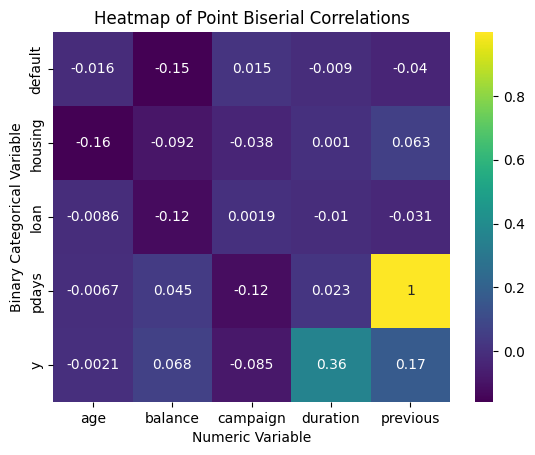

In [660]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer,QuantileTransformer,StandardScaler

x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
from scipy.stats import pointbiserialr

bin_cat_encoded_tr["y"] = y_tr

pipe_trans = Pipeline([("transform",PowerTransformer(method = "yeo-johnson")),("scale",StandardScaler())])
numeric_trans = pipe_trans.fit(numeric_tr).transform(numeric_tr)
numeric_trans_df = pd.DataFrame(numeric_trans, columns=numeric_tr.columns, index=numeric_tr.index)



# Initialize an empty list to store the results
correlations = []

# Iterate over each binary categorical variable
for binary_var_name in bin_cat_encoded_tr.columns:
    # Extract the binary variable as a Series
    binary_var = bin_cat_encoded_tr[binary_var_name]
    
    # Now iterate over each continuous variable
    for numeric_var_name in numeric_tr.columns:
        # Extract the continuous variable as a Series
        numeric_var = numeric_trans_df[numeric_var_name]
        
        # Calculate the point-biserial correlation coefficient
        corr, p_value = pointbiserialr(numeric_var, binary_var)
        
        # Store the results along with the variable names
        correlations.append({
            'Numeric Variable': numeric_var_name,
            'Binary Categorical Variable': binary_var_name,
            'Correlation': corr,
            'P-Value': p_value
        })
        
correlation_results = pd.DataFrame(correlations)

pivot_table = correlation_results.pivot(index="Binary Categorical Variable", columns="Numeric Variable", values="Correlation")


sns.heatmap(pivot_table, annot=True, cmap="viridis")
plt.title("Heatmap of Point Biserial Correlations")
plt.show()

Note that almost all these pairwise correlations are essentially linearly uncorrelated with the exception of pdays - previous, and y - duration. pdays and previous being perfectly correlated makes sense as we cannot record the number of contacts made (previous) if we have never contacted the client(as indicated by pdays). duration - y, are weakly correlated given the pointbiserial metric. However, we have seen already and will continue to see that this an important variable in our dataset. 

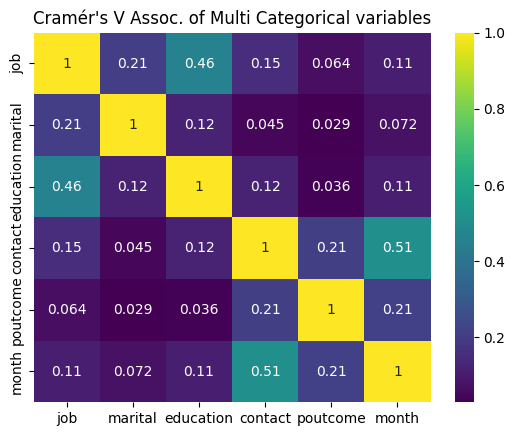

In [661]:
import association_metrics as am
import matplotlib.pyplot as plt
multi_cat = training_data[["job","marital","education","contact","poutcome","month"]]

df = multi_cat.apply(lambda x: x.astype("category") if x.dtype == "O" else x)
# Initialize a CramersV object using your pandas.DataFrame
cramersv = am.CramersV(df)

# This will return a pairwise matrix filled with Cramer's V, where columns and index are
# the categorical variables of the passed pandas.DataFrame
result = cramersv.fit()

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `result` is your Cramér's V matrix
sns.heatmap(result, annot=True, cmap="viridis")
plt.title("Cramér's V Assoc. of Multi Categorical variables")
plt.show()

We can use Cramers V statistic to see the association between two nominal variables with two or more levels. Values range from 0 (no association) to 1 (complete association). Notice once again that there are not many correlations.There two weak/mildly correlated variables that make intuitive sense. Education levels which seem to influence job types and the type of contact and the month of year (this one not as clear).

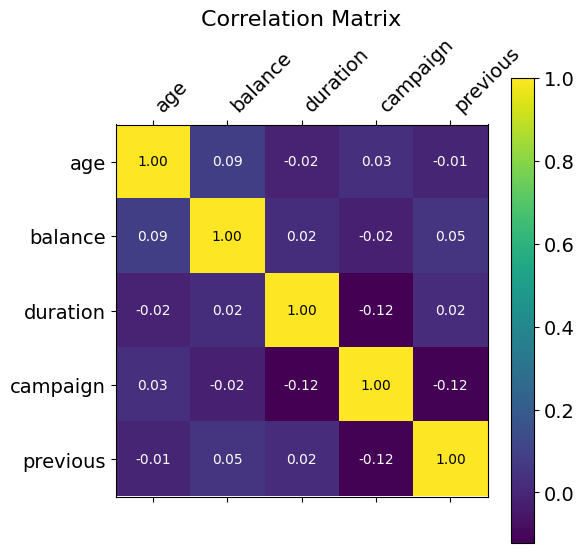

In [662]:
f = plt.figure(figsize=(6, 6))
plt.matshow(numeric_trans_df.corr(), fignum=f.number)
plt.xticks(range(numeric_trans_df.select_dtypes(['number']).shape[1]), numeric_trans_df.select_dtypes(['number']).columns, fontsize=14, rotation=45,ha = "left")
plt.yticks(range(numeric_trans_df.select_dtypes(['number']).shape[1]), numeric_trans_df.select_dtypes(['number']).columns, fontsize=14)
for (i, j), val in np.ndenumerate(numeric_trans_df.corr()):
    plt.text(
        j, i, f"{val:.2f}", 
        ha='center', va='center', 
        color='white' if np.abs(val) < 0.5 else 'black'
    )

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

When it comes to relationships between our numeric variables they are virtually uncorrelated. This is surpising in some sense, for example we might expect age to influence balance or perhaps previous to influence duration, but we see very little association here.

In [663]:
# function for applying yeo-johnson and standard scalar to numeric features 
def data_transform(df):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PowerTransformer,StandardScaler,MinMaxScaler
    bin_cat = df[["default","housing","loan","pdays"]]

    multi_cat = df[['job_admin.', 'job_blue-collar',
        'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
        'job_self-employed', 'job_services', 'job_student', 'job_technician',
        'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
        'marital_single', 'education_primary', 'education_secondary',
        'education_tertiary', 'education_unknown', 'contact_cellular',
        'contact_telephone', 'contact_unknown', 'poutcome_failure',
        'poutcome_other', 'poutcome_success', 'poutcome_unknown','month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep']]
    
    numeric = df[["age","balance","duration","campaign","previous"]]

# Let's try min/max scalar
    pipe_trans = Pipeline([("transform",PowerTransformer(method = "yeo-johnson")),("scale",StandardScaler())])
    numeric_trans = pipe_trans.fit(numeric).transform(numeric)
    numeric_df = pd.DataFrame(numeric_trans, columns=numeric.columns, index=numeric.index)
    

    return pd.concat([bin_cat,multi_cat,numeric_df],axis = 1)


## **KMeans - unsupervised learning**

Let's Implement a k means clustering model to see if we can find any interesting segments of clients, starting by trying to find the optimal number of k. 

In [664]:
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

In [665]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans,MiniBatchKMeans

x_tr = data_transform(x_tr)
x_tr = x_tr[["age","balance","duration","campaign","previous"]]
x_tr

wcss = {}
for k in range(1, 100):
    kmeans = MiniBatchKMeans(n_clusters=k, max_iter=100,n_init="auto").fit(x_tr)
    wcss[k] = kmeans.inertia_ 

# sc = {}
# for k in range(2,50):
#     kmeans = MiniBatchKMeans(n_clusters=k, max_iter=10,n_init="auto").fit(feature_df)
#     predicted_labels = kmeans.predict(feature_df)
#     sil_coeff = silhouette_score(feature_df,predicted_labels,metric = "euclidean",n_jobs = -1)
#     sc[k] = sil_coeff
    


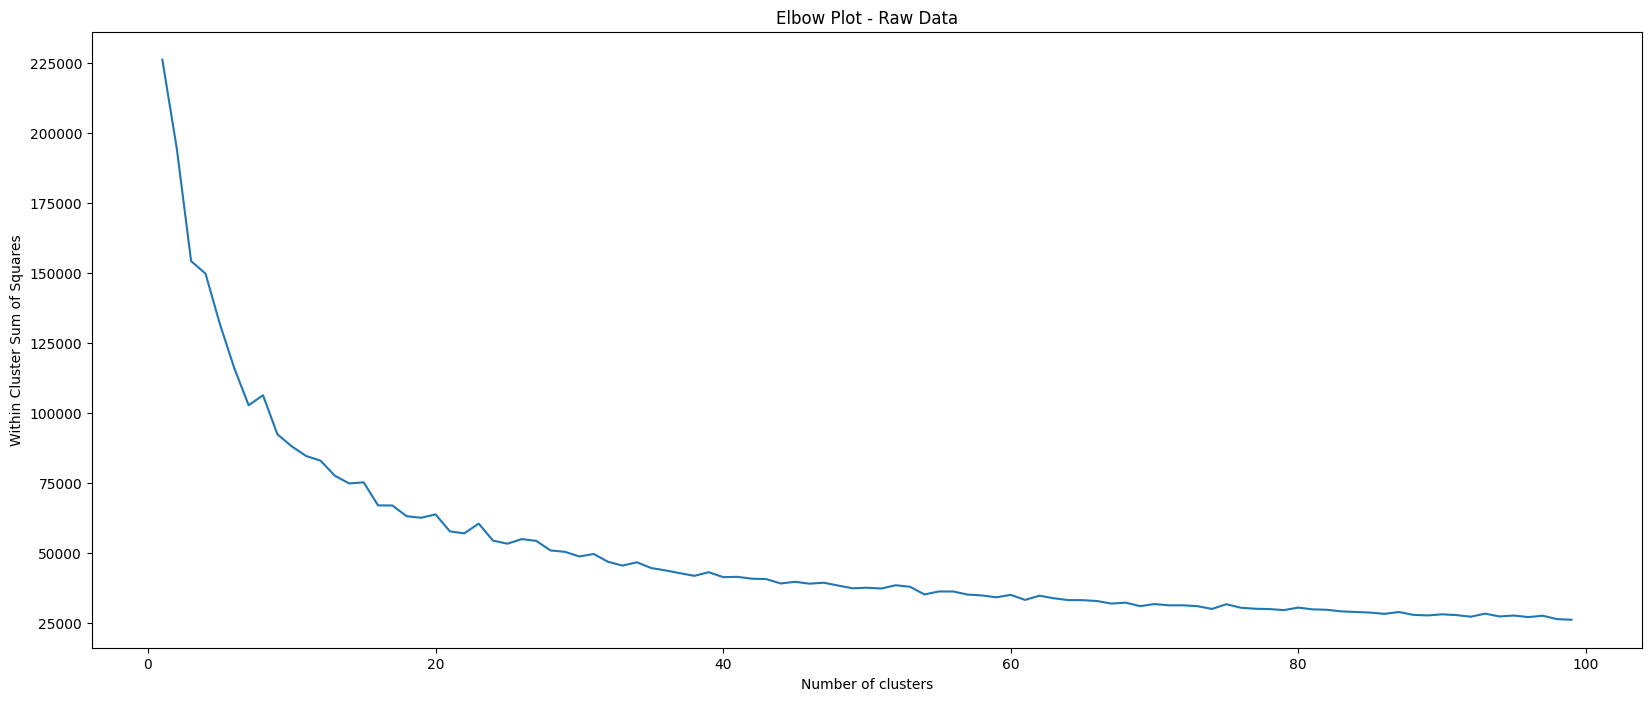

In [669]:

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

plt.plot(list(wcss.keys()), list(wcss.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Within Cluster Sum of Squares")
plt.title("Elbow Plot - Raw Data")
plt.ticklabel_format(style = "plain", axis = "y")
    

From the elbow plot there is no super clear cut off point and I chose not to include the silhouete score as it conflicted with the results of the WCSS. However, note that there is a huge reduction from about 0 to 15 clusters and then it gradually begins to decay. Through trial and error I chose to settle on 25 clusters. So in the assignment of the model I will be using k = 25. 

In [ ]:
# function for applying yeo-johnson and standard scalar to numeric features 
def data_transform(df):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PowerTransformer,StandardScaler,MinMaxScaler
    bin_cat = df[["default","housing","loan","pdays"]]

    multi_cat = df[['job_admin.', 'job_blue-collar',
        'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
        'job_self-employed', 'job_services', 'job_student', 'job_technician',
        'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
        'marital_single', 'education_primary', 'education_secondary',
        'education_tertiary', 'education_unknown', 'contact_cellular',
        'contact_telephone', 'contact_unknown', 'poutcome_failure',
        'poutcome_other', 'poutcome_success', 'poutcome_unknown']]
    
    numeric = df[["age","balance","duration","campaign","previous"]]

# Let's try min/max scalar
    pipe_trans = Pipeline([("transform",PowerTransformer(method = "yeo-johnson")),("scale",StandardScaler())])
    numeric_trans = pipe_trans.fit(numeric).transform(numeric)
    numeric_df = pd.DataFrame(numeric_trans, columns=numeric.columns, index=numeric.index)
    

    return pd.concat([bin_cat,multi_cat,numeric_df],axis = 1)


In [ ]:
# from sklearn.cluster import KMeans,MiniBatchKMeans

# x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

# # x_tr = data_transform(x_tr)
# # x_tr = x_tr[["age","balance","duration","campaign","previous"]]
# x_tr

# kmeans = KMeans(n_clusters = 25,n_init = "auto",random_state= 0)
# kmeans.fit(x_tr)
# labels = kmeans.predict(x_tr)
# x_tr["k_means_clusters"] = pd.Series(labels)
# x_tr["y"] = training_data["y"]

# x_tr['y_encoded'] = x_tr['y'].apply(lambda x: 1 if x == 'yes' else 0)
# proportions = x_tr.groupby('k_means_clusters')['y_encoded'].mean()
# proportions_df = proportions.reset_index().rename(columns={'y_encoded': 'proportion_yes'})
# proportions_df

Calculating the proportion of those who accepted the offer in each cluster:

In [ ]:
import joblib
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
# Save the model
# joblib.dump(kmeans, 'kmeans_model.pkl')

# To load the model later and predict
kmeans_loaded = joblib.load('kmeans_model.pkl')
labels_loaded = kmeans_loaded.predict(x_tr)
x_tr["k_means_clusters"] = pd.Series(labels_loaded)
x_tr["y"] = training_data["y"]

x_tr['y_encoded'] = x_tr['y'].apply(lambda x: 1 if x == 'yes' else 0)
proportions = x_tr.groupby('k_means_clusters')['y_encoded'].mean()
proportions_df = proportions.reset_index().rename(columns={'y_encoded': 'proportion_yes'})
proportions_df

,k_means_clusters,proportion_yes
0,0,0.168582
1,1,0.120000
2,2,0.040441
3,3,0.172648
4,4,0.153846
5,5,0.139706
6,6,0.107692
7,7,0.181818
8,8,0.097232
9,9,0.000000


We can see cluster 22 has a 66.66% of those who said yes. Let's take a look at the means of each feature within that cluster:

In [ ]:
many_yes = x_tr.loc[x_tr["k_means_clusters"] == 22].mean(numeric_only=True)
mask = many_yes > 0
means_of_cluster = pd.DataFrame((many_yes[mask]).round(2), columns=["Means of cluster 22"])
means_of_cluster

,Means of cluster 22
pdays,0.67
job_retired,1.00
marital_married,1.00
education_primary,0.33
education_secondary,0.67
contact_cellular,0.33
contact_telephone,0.67
poutcome_other,0.33
poutcome_success,0.33
poutcome_unknown,0.33


While the way I fitted this model may not be technically correct (including hot encoded variables as well as not transforming the numeric variables), from several iterations and experimentation this was one of the most interesting labels. Very cleary, these are a group old school retirees.The mean age, balance, and acceptance of the term deposit offer is  76, $77,865, and 67%. All of these people are retired, married, and most of them still speak on a landline. There are only 49 people with this label, however, they are excellent candidates for the term deposit offer and group of clients we should defintely keep in mind for future campaigns

Note: I am redfining my load_raw_data() function to combine the original training and testing data and then randomly reassign it. I was getting 100% accuracy with Random Forests and the XGB Boost model. This could be due to chance or perhaps the training data was pre enginereed/processed in some way not apparant to me. By reshuffling data, the perfect scores do not occur. I believe this way is much more represetative of the true performance of the models. 

In [6]:
# hot encode months or change them into 4 seasons 
# changing p days into binary variable 

def load_raw_data():

    from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    
    train = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\train_banking_marketing.parquet")
    test= pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\test-banking_marketing.parquet")
    
    combined_df = pd.concat([train,test])
    combined_df
    
    training_data, testing_data = train_test_split(combined_df,test_size = .1,random_state = 42)

    training_data = training_data
    testing_data = testing_data
    

    features_tr = training_data.drop(columns = ["y"])
    features_te = testing_data.drop(columns = ["y"])
    features_tr['pdays'] = np.where(features_tr['pdays'] == -1, "no", "yes")
    features_te['pdays'] = np.where(features_te['pdays'] == -1, "no", "yes")


    hot_encoder = OneHotEncoder(sparse_output = False).set_output(transform="pandas")
    ord_encoder = OrdinalEncoder().set_output(transform = "pandas")

    bin_cat_tr = features_tr[["default","housing","loan","pdays"]]
    multi_cat_tr = features_tr[["job","marital","education","contact","poutcome","month"]]

    multi_cat_encoded_tr = hot_encoder.fit_transform(multi_cat_tr)
    bin_cat_encoded_tr = ord_encoder.fit_transform(bin_cat_tr)
    numeric_tr = features_tr[["age","balance","duration","campaign","previous"]]

    x_tr = pd.concat([bin_cat_encoded_tr,multi_cat_encoded_tr,numeric_tr],axis = 1)
    y_tr = np.where(training_data["y"] == "yes", 1,0)
    
    bin_cat_te = features_te[["default","housing","loan","pdays"]]
    multi_cat_te = features_te[["job","marital","education","contact","poutcome","month"]]

    multi_cat_encoded_te = hot_encoder.transform(multi_cat_te)
    bin_cat_encoded_te = ord_encoder.transform(bin_cat_te)
    numeric_te = features_te[["age","balance","duration","campaign","previous"]]

    x_te = pd.concat([bin_cat_encoded_te,multi_cat_encoded_te,numeric_te],axis = 1)
    y_te = np.where(testing_data["y"] == "yes", 1,0)
    
    
    return x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te

In [691]:
# function for converting pdays to categorical
def data_transform(df):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PowerTransformer,StandardScaler,MinMaxScaler
    bin_cat = df[["default","housing","loan","pdays"]]

    multi_cat = df[['job_admin.', 'job_blue-collar',
        'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
        'job_self-employed', 'job_services', 'job_student', 'job_technician',
        'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
        'marital_single', 'education_primary', 'education_secondary',
        'education_tertiary', 'education_unknown', 'contact_cellular',
        'contact_telephone', 'contact_unknown', 'poutcome_failure',
        'poutcome_other', 'poutcome_success', 'poutcome_unknown','month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep']]
    
    numeric = df[["age","balance","duration","campaign","previous"]]

# Let's try min/max scalar
    pipe_trans = Pipeline([("transform",PowerTransformer(method = "yeo-johnson")),("scale",StandardScaler())])
    numeric_trans = pipe_trans.fit(numeric).transform(numeric)
    numeric_df = pd.DataFrame(numeric_trans, columns=numeric.columns, index=numeric.index)
    

    return pd.concat([bin_cat,multi_cat,numeric_df],axis = 1)


In [692]:
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
prop_of_yes_train = (y_tr.sum() / len(y_tr)) * 100
prop_of_yes_test = (y_te.sum() / len(y_te)) * 100
print(f"""Because {prop_of_yes_train:.2f}% of people in the training set said yes to the term deposit offer (prop of yes). The most Naive model would assume this average as it's 
conversion rate, making it {100 - prop_of_yes_train:.2f}% accurate. The proportions in the test set are {prop_of_yes_test:.2f}% yes and {100 - prop_of_yes_test:.2f}% no""")

Because 11.63% of people in the training set said yes to the term deposit offer (prop of yes). The most Naive model would assume this average as it's 
conversion rate, making it 88.37% accurate. The proportions in the test set are 12.12% yes and 87.88% no


The most naive model, given the class imbalance would assume that every person would say no to the term deposit offer. This would make the model 88.37% accurate. Alternatively, you could simply use the mean to forecast what percent of clients you think would convert (eg. 11.63%). It turns out with this data, that the mean estimate would be extremely accurate. However, thinking of it this way you do not really have a mechanism of deciding who would say yes. You could randomly select assign the success's, however for this project I was will assume the former approach of assuming everyone will say no as the most naive model. This will come up later when we look at model evaluation. Now we will fit some classification models. 

## **Regularized Logistic Regression**

First let's begin by finishing the optimal lambda for both ridge and lasso, logistic regression. 

In [693]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score,StratifiedKFold

# Lasso - Logistic Regularization

x_tr = data_transform(x_tr)
x_te = data_transform(x_te)


# fitting and testing model
C = [.4,.5,.6,.7]
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_lasso = []
scores_ridge =[]

print("Finding the optimal lambda for Lasso Regression")

for i in C:
    ridge_reg = LogisticRegression(penalty="l1",random_state=42,max_iter=1000,solver = "liblinear",C = i,tol = .00001).fit(x_tr,y_tr)
    avg_cross_val_ridge = cross_val_score(lasso_reg,x_tr,y_tr,cv = strat_kfold).mean()
    print(f"For C = {i}, cross val scores = {cross_val_score(lasso_reg,x_tr,y_tr,cv = strat_kfold)}")
    scores_lasso.append(avg_cross_val_ridge)    
    
    
print("Finding the optimal lambda for Ridge Regression")    
for i in C:
    ridge_reg = LogisticRegression(penalty="l2",random_state=42,max_iter=1000,solver = "liblinear",C = i,tol = .00001).fit(x_tr,y_tr)
    avg_cross_val_lasso = cross_val_score(ridge_reg,x_tr,y_tr,cv = strat_kfold).mean()
    print(f"For C = {i}, cross val scores = {cross_val_score(ridge_reg,x_tr,y_tr,cv = strat_kfold)}")
    scores_ridge.append(avg_cross_val_lasso)
          
best_lasso = max(scores_lasso)
best_ridge = max(scores_ridge) 

print(f"{best_lasso:.4f},{best_ridge:4f}")
    

Finding the optimal lambda for Lasso Regression
For C = 0.4, cross val scores = [0.90493744 0.90437891 0.90404379 0.89688303 0.90313931]
For C = 0.5, cross val scores = [0.90493744 0.90437891 0.90404379 0.89688303 0.90313931]
For C = 0.6, cross val scores = [0.90493744 0.90437891 0.90404379 0.89688303 0.90313931]
For C = 0.7, cross val scores = [0.90493744 0.90437891 0.90404379 0.89688303 0.90313931]
Finding the optimal lambda for Ridge Regression
For C = 0.4, cross val scores = [0.90504915 0.90437891 0.90393208 0.89665959 0.90313931]
For C = 0.5, cross val scores = [0.90504915 0.90449062 0.90404379 0.89654787 0.90313931]
For C = 0.6, cross val scores = [0.90504915 0.90437891 0.90404379 0.89643615 0.90347447]
For C = 0.7, cross val scores = [0.90504915 0.90437891 0.9041555  0.89654787 0.90347447]
0.9027,0.902721


In [694]:
optimal_lambda_lasso = C[np.argmax(scores_lasso)]
optimal_lambda_ridge = C[np.argmax(scores_ridge)]
print(f"Best C for Lasso {optimal_lambda_lasso}, Best C for Ridge {optimal_lambda_ridge}")

Best C for Lasso 0.4, Best C for Ridge 0.7


Next let's try and find the best decsion threshold.

In [696]:
def custom_predict(model, X, threshold= thresh):
    # Get the probability of the positive class
    proba = model.predict_proba(X)[:, 1]
    # Apply the threshold to decide between the positive and negative class
    return np.where(proba > threshold, 1, 0)

LASSO:

In [699]:
from sklearn.metrics import accuracy_score

lasso_reg = LogisticRegression(penalty= "l1",random_state=42,max_iter=1000,solver = "liblinear",C = .4,tol = .00001).fit(x_tr,y_tr)

thresholds = [.2,.3,.4,.5,.6,.7,.8,.9]

print("Adjusting decision threshold")
for thresh in thresholds:
    predictions = custom_predict(ridge_reg, x_tr, threshold=thresh)  # You can adjust the threshold as needed
    accuracy = accuracy_score(y_tr, predictions)
    print(f"Accuracy with threshold {thresh}:, {accuracy:.4f}")

print("Adjusting decision threshold - More refined")
thresholds = [.4,.41,.42,.43,.44,.45,.46,.47,.48,.49]
for thresh in thresholds:
    predictions = custom_predict(lasso_reg, x_tr, threshold=thresh)  # You can adjust the threshold as needed
    accuracy = accuracy_score(y_tr, predictions)
    print(f"Accuracy with threshold {thresh}:, {accuracy:.4f}")
    


print("testing based of best cross val parameters")
test_predictions = custom_predict(lasso_reg,x_te,threshold=.44)
test_accuracy = accuracy_score(y_te, test_predictions)
print(f"final test accuracy {test_accuracy:.4f}")

print(f"Optimal Decision Threshold 0.43")


Adjusting decision threshold
Accuracy with threshold 0.2:, 0.8746
Accuracy with threshold 0.3:, 0.8978
Accuracy with threshold 0.4:, 0.9038
Accuracy with threshold 0.5:, 0.9030
Accuracy with threshold 0.6:, 0.9002
Accuracy with threshold 0.7:, 0.8966
Accuracy with threshold 0.8:, 0.8921
Accuracy with threshold 0.9:, 0.8867
Adjusting decision threshold - More refined
Accuracy with threshold 0.4:, 0.9040
Accuracy with threshold 0.41:, 0.9043
Accuracy with threshold 0.42:, 0.9046
Accuracy with threshold 0.43:, 0.9047
Accuracy with threshold 0.44:, 0.9046
Accuracy with threshold 0.45:, 0.9046
Accuracy with threshold 0.46:, 0.9043
Accuracy with threshold 0.47:, 0.9037
Accuracy with threshold 0.48:, 0.9031
Accuracy with threshold 0.49:, 0.9027
testing based of best cross val parameters
final test accuracy 0.9025
Optimal Decision Threshold 0.43


In [700]:
from sklearn.metrics import accuracy_score
# Ridge Regression

ridge_reg = LogisticRegression(penalty="l2",random_state=42,max_iter=1000,solver = "liblinear",C = .1,tol = .00001).fit(x_tr,y_tr)

thresholds = [.2,.3,.4,.5,.6,.7,.8,.9]

print("Adjusting decision threshold: 0.2 to 0.9")
for thresh in thresholds:
    predictions = custom_predict(ridge_reg, x_tr, threshold=thresh)  # You can adjust the threshold as needed
    accuracy = accuracy_score(y_tr, predictions)
    print(f"Accuracy with threshold {thresh}:, {accuracy:.4f}")

print(" ")

print("Adjusting decision threshold: 0.4 to 0.5")
thresholds = [.4,.41,.42,.43,.44,.45,.46,.47,.48,.49]
for thresh in thresholds:
    predictions = custom_predict(ridge_reg, x_tr, threshold=thresh)  # You can adjust the threshold as needed
    accuracy = accuracy_score(y_tr, predictions)
    print(f"Accuracy with threshold {thresh}:, {accuracy:.4f}")

test_predictions = custom_predict(ridge_reg,x_te,threshold=.46)
test_accuracy = accuracy_score(y_te, test_predictions)
print(f"final test accuracy {test_accuracy:.4f}")

Adjusting decision threshold: 0.2 to 0.9
Accuracy with threshold 0.2:, 0.8746
Accuracy with threshold 0.3:, 0.8978
Accuracy with threshold 0.4:, 0.9038
Accuracy with threshold 0.5:, 0.9030
Accuracy with threshold 0.6:, 0.9002
Accuracy with threshold 0.7:, 0.8966
Accuracy with threshold 0.8:, 0.8921
Accuracy with threshold 0.9:, 0.8867
 
Adjusting decision threshold: 0.4 to 0.5
Accuracy with threshold 0.4:, 0.9038
Accuracy with threshold 0.41:, 0.9044
Accuracy with threshold 0.42:, 0.9044
Accuracy with threshold 0.43:, 0.9044
Accuracy with threshold 0.44:, 0.9044
Accuracy with threshold 0.45:, 0.9042
Accuracy with threshold 0.46:, 0.9038
Accuracy with threshold 0.47:, 0.9037
Accuracy with threshold 0.48:, 0.9028
Accuracy with threshold 0.49:, 0.9030
final test accuracy 0.9039


Tuning steps = optimizing lambda, tolerance, and decision threshold for Ridge and LASSO. Also tried other solvers, adjusting class weight to "balanced" and elasticnet mixing parameter. Lasso with tol = .00001, C = .4 and decision threshold = .44 for Lasso yielded the highest test accuracy of 90.25% and the same paramters for ridge except for  C = .7 yielded a test accuracy of 90.39%.Let's have a look at what features Lasso estimated logit coefficients of 0 for. 

In [702]:
lasso_reg = LogisticRegression(penalty= "l1",random_state=42,max_iter=1000,solver = "liblinear",C = .41,tol = .00001).fit(x_tr,y_tr)
# seperating sig from non sig betas 
logit_betas = pd.DataFrame(lasso_reg.coef_.T,index = x_tr.columns,columns = ["Lasso Betas"])
logit_betas.sort_values(by = ["Lasso Betas"],inplace=True,ascending=False)
mask = logit_betas["Lasso Betas"] == 0
sig_betas = logit_betas[~mask]
non_sig_beta = logit_betas[mask]
non_sig_beta

,Lasso Betas
education_secondary,0.0
month_apr,0.0
poutcome_unknown,0.0
poutcome_other,0.0
education_unknown,0.0
default,0.0
contact_cellular,0.0
pdays,0.0
marital_divorced,0.0
job_unknown,0.0


These are the variables that are not important according to the optimized LASSO model. Some are not surprising while some may be. For example if a person has defaulted we might expect them to have a reduced chance of accepting the offer. Let's visualize the variables that are and there estimated betas.

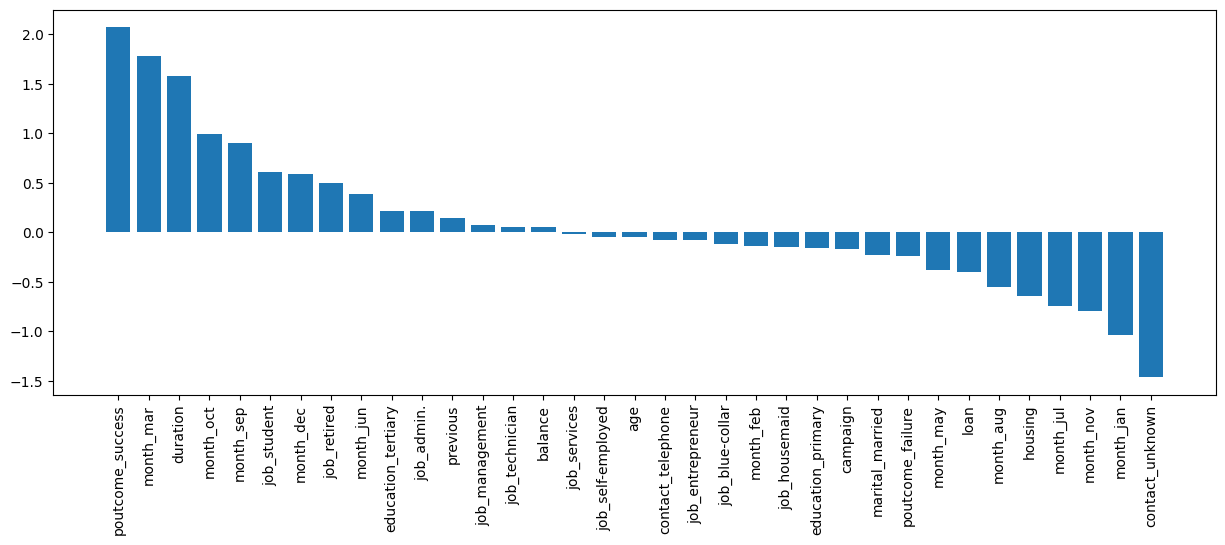

35
47


In [703]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (15,5))
plt.bar(sig_betas.index,sig_betas["Lasso Betas"])
plt.xticks(rotation=90)
plt.show()

print(len(sig_betas))
print(len(x_tr.columns))

Lasso Regression reduced the features from 47 to 35, which is advantageous as it makes the model more simple. Here we can see the previous outcome of the last campaign being a success having the largest effect on the prob of a client accepting an offer under this model. This is in line with what we saw earlier by just looking at the proportions. Next is followed by month of march and duration (as seen to be important earlier as well). students, retirees, and those with "tertiary" education are the next most likely. From my personal experience this also makes sense. Students while usually having less money are more easily influenced than say mature adults and retirees are typically looking for safe guaranteed investments with guaranteed rates of return. It is interesting that age, balance and other variables that might seem like they would make a material difference in ones decision to invest in a term deposit, are not important with this model

## **Bayesian Classifiers**

Next let's use a series of bayesian classifiers to estimate the binary classifcation 

In [704]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,CategoricalNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
# Using numeric features to fit Bayes classifiers with the normal dist assumption
x_tr = data_transform(x_tr)
x_te = data_transform(x_te)

num_train = x_tr[["age","balance","duration","campaign","previous"]]
num_test = x_te[["age","balance","duration","campaign","previous"]]

nb = GaussianNB()
nb.fit(num_train,y_tr)

lda = lda()
lda.fit(num_train,y_tr)

qda = qda()
qda_fit = qda.fit(num_train,y_tr)


In [705]:
# using categorical NB with categorical features only!
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

cat_train = pd.concat([bin_cat_encoded_tr,multi_cat_encoded_tr],axis = 1)
cat_test = pd.concat([bin_cat_encoded_te,multi_cat_encoded_te],axis = 1)

cat_nb = CategoricalNB()
cat_fit = cat_nb.fit(cat_train,y_tr)



In [682]:
# using multinomial nb classifier
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

cat_train = pd.concat([bin_cat_encoded_tr,multi_cat_encoded_tr],axis = 1)
cat_test = pd.concat([bin_cat_encoded_te,multi_cat_encoded_te],axis = 1)

multi_nb = MultinomialNB()
multi_nb = multi_nb.fit(cat_train,y_tr)


In [706]:
print(f"Naive Bayes {nb.score(num_test,y_te):.4f}")
print(f"QDA Score {qda.score(num_test,y_te):.4f}")
print(f"LDA Score {lda.score(num_test,y_te):.4f}")
print(f"Categorical NB {cat_nb.score(cat_test,y_te):.4f}")
print(f"Multinomial NB {multi_nb.score(cat_test,y_te):.4f}")

Naive Bayes 0.8764
QDA Score 0.8782
LDA Score 0.8814
Categorical NB 0.8496
Multinomial NB 0.8772


Here we can see that all form of bayesian classifiers perform worse than the logistic regression. It is important to remember the many assumptions behind these models. For example NB, LDA, and QDA assume that variables follow a gaussian distribution. But recall that most of the variables in these dataset are categorical and do not follow a continous normal dist. I fit the NB, LDA, and QDA with numeric variables only, but the performance is not as strong as the logistic reg. I also fit Categorical NB and Multinomial NB using only the categorical variables and the performance is similar or worse. I think this is because you are losing information important for the response variable when you cannot include the relationships of the numeric and categorical variables in tandem. Even though we saw earlier that most variables do not appear linearly correlated, I think the associations between variables and different levels of these variables are more nuanced and not neccesarily linear.

## **Decision Trees**

Let's now move forward with a robust non-parametric approach to the classification problem.We will start with a regular Decision Tree Classifier and look at tuning the maximum depth and number of minimum leaf samples.

In [707]:
# load in data and do not transform
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
from sklearn.tree import DecisionTreeClassifier 
# tuning max_depth and min_sample_leaf manually

max_depth = list(range(5,20))
min_sample_leaf = list(range(5,30))

scores = []
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i in max_depth:
    for j in min_sample_leaf:
        tree = DecisionTreeClassifier(criterion = "gini",max_depth= i ,min_samples_leaf = j,random_state=42)
        tree.fit(x_tr,y_tr)
        score = ({"max depth" : i,"min leafs" : j,"accuracy" : cross_val_score(tree,x_te,y_te,cv=strat_kfold,n_jobs = -1).mean()})
        scores.append(score)

tuning_df = pd.DataFrame(scores)
tuning_df.sort_values(by = "accuracy",ascending = False).head()

,max depth,min leafs,accuracy
10,5,15,0.899073
9,5,14,0.899073
8,5,13,0.898872
15,5,20,0.898470
11,5,16,0.898469


The optimal tree under this manual grid search approach for these paramteres is max_depth = 5 and min_leafs = 15

Test Accuracy of optimized tree 0.9007


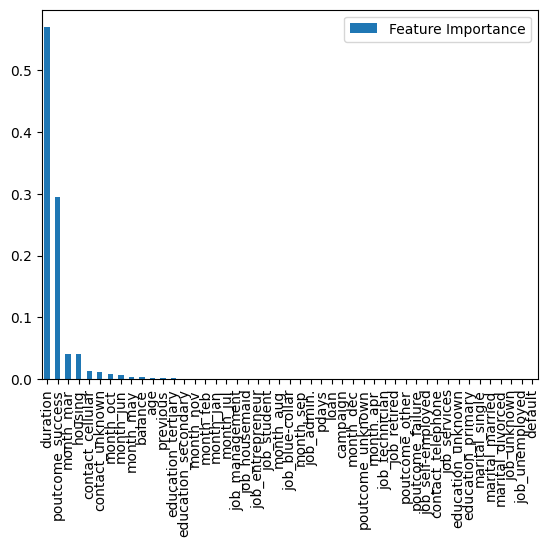

In [708]:
tree = DecisionTreeClassifier(criterion = "gini",max_depth=5 ,min_samples_leaf = 15,random_state=42)
tree.fit(x_tr,y_tr)

test_score = tree.score(x_te,y_te)
print(f"Test Accuracy of optimized tree {test_score:.4f}")

feature_importance = pd.DataFrame(tree.feature_importances_,index = x_tr.columns,columns = ["Feature Importance"])
feature_importance.sort_values(by = "Feature Importance",ascending = False,inplace=True)
feature_importance.plot(kind="bar")
plt.show()


The test accuracy for this tree is 90.07%, less than the logistic regression. Notice that in this model duration is the most imporant feature. Let's use a more robust and typically more generalizable random forest classifier.

In [711]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np


strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100], 
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],  
}

rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1)


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=strat_kfold, n_jobs=-1, scoring='accuracy')

grid_search.fit(x_tr, y_tr)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Test the best model
test_score = grid_search.best_estimator_.score(x_te, y_te)
print(f"Test accuracy: {test_score:.4f}")


Best parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9160
Test accuracy: 0.9184


The Random Forest is so far our best performer at 91.84% accuracy. Let's again view the feature importance.

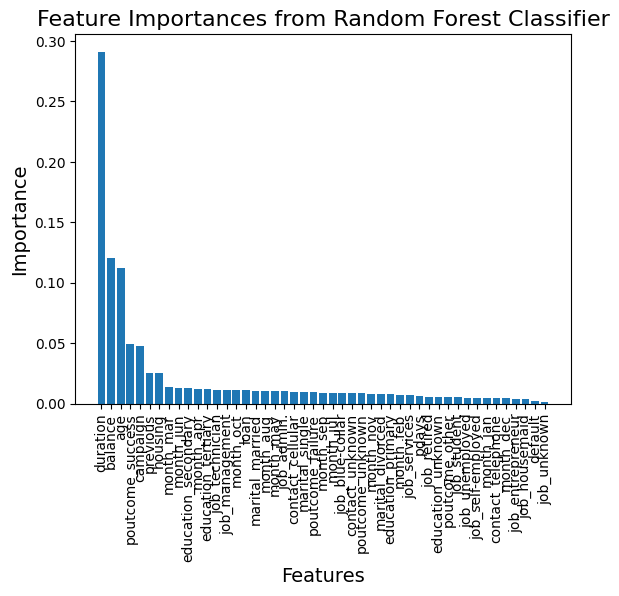

In [712]:
import pandas as pd
importances = random_forest.feature_importances_
feature_importances = pd.DataFrame({'Feature': x_tr.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure()  # Adjust the size as needed
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.xticks(rotation='vertical')  # Rotates feature names for readability
plt.title('Feature Importances from Random Forest Classifier', fontsize=16)
plt.show()



Reviewing the feature importance, it makes sense why this model would perform better. Now, some of those other features which probably do influence the outcome of the offer are being incorporated into the model.Notice that balance has now become the second most signicant variable. Variables like age, campaign, and previous have also become much more signicant. These are the variables that seem very congruent with my experiance as a former financial advisor (much like a salesmen) when selling GIC's (essentially a term deposit offer). This seems like the most logical and is the best performing model so far. 

In [718]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


boosted_model = XGBClassifier(objective='binary:logistic', learning_rate=0.1,
                              max_depth=20, n_estimators=50, 
                              use_label_encoder=False, 
                              enable_categorical=True)


strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

cv_scores = cross_val_score(boosted_model, x_tr, y_tr, cv=strat_kfold, scoring='accuracy')
cv_score_avg = cv_scores.mean()

boosted_model.fit(x_tr, y_tr)


test_score = boosted_model.score(x_te, y_te)


print(f"""With a gradient Boosted tree the cross validated training accuracy score is {cv_score_avg:.4f} with a test accuracy score of {test_score:.4f}""")


With a gradient Boosted tree the cross validated training accuracy score is 0.9132 with a test accuracy score of 0.9162


The Gradient Boosted tree performs very similar to the Random Forest.Indicating that trees may be a good method for this classification problem

## **KNN Classification**

We are now going to try KNN another classification algorithm that is well suited for modeling non linear relationships, however it also suffers from the curse of dimensionality, which we have quite a few off. We will try KNN with all dimensions, Lasso selected features , and feature importance as indicated from the first Decision tree classifier. We are doing this try and reduce the dimensions to see if it can help the model perform better.

In [720]:
feature_importance
mask_tree = feature_importance["Feature Importance"] == 0
sig_splits = feature_importance[~mask_tree]
non_sig_splits = feature_importance[mask_tree]

In [721]:
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

# KNN Classification
from sklearn.neighbors import KNeighborsClassifier

x_tr = data_transform(x_tr)
x_te = data_transform(x_te)

log_feat_train = x_tr[column_names]
log_feat_test = x_te[column_names]

tree_import_train = x_tr[sig_splits.index]
tree_import_test = x_te[sig_splits.index]

# list_of_k = list(range(1,300,20))
list_of_k = list(range(1,20))

scores_raw = []
scores_lasso = []
scores_tree = []

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

for k in list_of_k:
    knn_class = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(knn_class,x_tr,y_tr,cv = strat_kfold,n_jobs=-1).mean()
    scores_raw.append(cv_score)
    # print(f"Value of K = {k}, cv score = {cv_score:.4f}")
    
for k in list_of_k:
    knn_class = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(knn_class,log_feat_train,y_tr,cv = strat_kfold,n_jobs=-1).mean()
    scores_lasso.append(cv_score)
    # print(f"Value of K = {k}, cv score = {cv_score:.4f}")
    
for k in list_of_k:
    knn_class = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(knn_class,tree_import_train,y_tr,cv = strat_kfold,n_jobs=-1).mean()
    scores_tree.append(cv_score)
    # print(f"Value of K = {k}, cv score = {cv_score:.4f}")


In [723]:
optimal_k= list_of_k[np.argmax(scores_raw)]
optimal_cv_score = scores_raw[np.argmax(scores_raw)]
print(f"Optimal CV Score for all features {optimal_cv_score:.4f}")
optimal_knn = KNeighborsClassifier(n_neighbors = optimal_k).fit(x_tr,y_tr)
test_knn_score = optimal_knn.score(x_te,y_te)
print(f"The optimal k for all features given k = {optimal_k} with a test score = {test_knn_score:.4f}")

print()

optimal_k= list_of_k[np.argmax(scores_lasso)]
optimal_cv_score = scores_lasso[np.argmax(scores_lasso)]
print(f"Optimal CV Score for Lasso selected features {optimal_cv_score:.4f}")
optimal_knn = KNeighborsClassifier(n_neighbors = optimal_k).fit(log_feat_train,y_tr)
test_knn_score = optimal_knn.score(log_feat_test,y_te)
print(f"The optimal k given Lasso Selected Features is k = {optimal_k} with a test score = {test_knn_score:.4f}")

print()

optimal_k= list_of_k[np.argmax(scores_tree)]
optimal_cv_score = scores_tree[np.argmax(scores_tree)]
print(f"Optimal CV Score for Decision Tree selected {optimal_cv_score:.4f}")
optimal_knn = KNeighborsClassifier(n_neighbors = optimal_k).fit(tree_import_train,y_tr)
test_knn_score = optimal_knn.score(tree_import_test,y_te)
print(f"The optimal k given Decision Tree Selected Features k = {optimal_k} with a test score = {test_knn_score:.4f}")

Optimal CV Score for all features 0.8991
The optimal k for all features given k = 13 with a test score = 0.8979

Optimal CV Score for Lasso selected features 0.8988
The optimal k given Lasso Selected Features is k = 19 with a test score = 0.8951

Optimal CV Score for Decision Tree selected 0.8998
The optimal k given Decision Tree Selected Features k = 19 with a test score = 0.8983


All three KNN models performed extremely similarly with the reduced decision tree feature importance variables performing the best at 89.83% accuracy.Let's try a different form of dimensionality reduction with FAMD and refit a KNN model.  

In [742]:
def data_transform2(df):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PowerTransformer,StandardScaler
 
    df['pdays'] = np.where(df['pdays'] == -1, "no", "yes")

    categorical = df[["job","marital","education","default","housing","loan","contact","month","pdays","poutcome"]]

    numeric = df[["age","balance","duration","campaign","previous"]]


    pipe_trans = Pipeline([("transform",PowerTransformer(method = "yeo-johnson")),("scale",StandardScaler())])
    numeric_trans = pipe_trans.fit(numeric).transform(numeric)

        # Reconstructing the numeric dataframe with original indexes
    numeric_df = pd.DataFrame(numeric_trans, columns=numeric.columns, index=df.index)

    # Concatenating the transformed numeric dataframe with the original categorical dataframe
    transformed_df = pd.concat([categorical, numeric_df], axis=1)

    return transformed_df



In [743]:
from prince import PCA, MCA, FAMD

training_data = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\train_banking_marketing.parquet")
testing_data = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\test-banking_marketing.parquet")
training_data = data_transform2(training_data)
testing_data = data_transform2(testing_data)

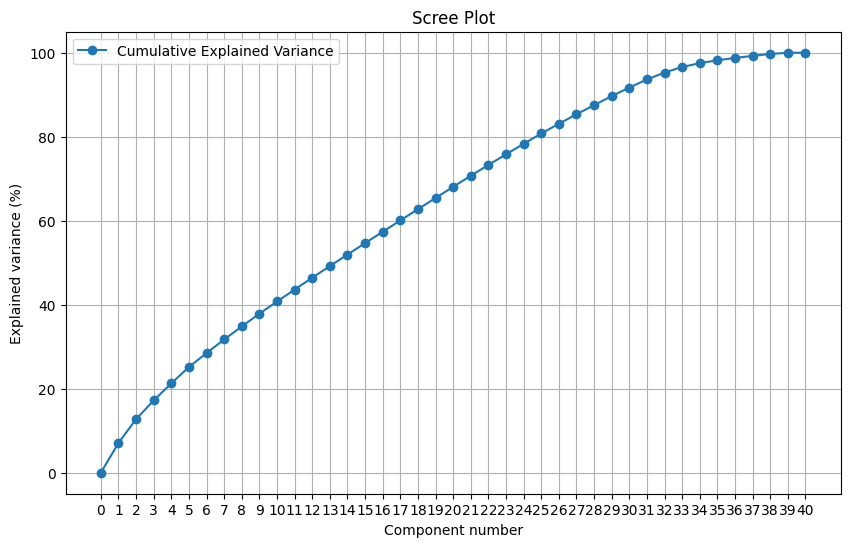

The first component where cumulative variance is greater than or equal to 90% is 30


In [744]:

for col in training_data.select_dtypes(include=['int64']).columns:
    training_data[col] = training_data[col].astype(float)

famd = FAMD(
    n_components=40,
    n_iter=100,
    copy=True,
    check_input=False,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)

famd1 = famd.fit(training_data)

famd_comp = famd1.eigenvalues_summary

eigenvalues = famd_comp['eigenvalue']
cumulative_variance = famd_comp['% of variance (cumulative)'].str.rstrip('%').astype('float')

component_numbers = eigenvalues.index + 1

plt.figure(figsize=(10, 6))
plt.plot([0] + list(component_numbers), [0] + list(cumulative_variance.values), 'o-', label='Cumulative Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Component number')
plt.ylabel('Explained variance (%)')
plt.xticks(range(len(component_numbers) + 1)) 
plt.legend()
plt.grid(True)
plt.show()


comp_90 = cumulative_variance >= 90
first_component_90 = comp_90.idxmax()

print("The first component where cumulative variance is greater than or equal to 90% is", first_component_90 + 1)

From the scree plot, we again see evidence that our features have fairly low correlations amongst one another. It takes 30 variables to explain 90% of the variation and about 38 to explain 100% (from the original 47). Also notice that there is greater variance being explained with the first few components, however it is not a quickly accelerating curve and is quite linear. Indicating that each pca is explaining some different aspect of the variation.  

In [745]:
famd1.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
age,0%,0%,3%,0%,1%,1%,0%,0%,0%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,92%,0%
balance,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,2%,93%,2%,1%,0%
duration,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,69%,0%,29%,0%,0%
campaign,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,0%,0%,0%,1%,0%,0%,25%,3%,68%,0%,0%
previous,6%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,17%
contact,3%,1%,2%,3%,0%,1%,2%,0%,0%,2%,0%,0%,1%,0%,0%,0%,0%,0%,0%,0%,0%,1%,2%,0%,4%,2%,0%,1%,1%,1%,0%,0%,1%,0%,10%,0%,0%,0%,0%,0%
default,0%,0%,0%,0%,0%,0%,1%,0%,0%,4%,1%,1%,0%,1%,0%,0%,0%,1%,1%,0%,2%,1%,2%,2%,3%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
education,0%,3%,5%,4%,5%,2%,2%,5%,1%,0%,0%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,8%,0%,0%,0%,3%,9%,0%,10%,0%,0%,0%,0%,0%,0%
housing,0%,4%,1%,0%,1%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,0%,0%,0%,11%,0%,0%,0%,0%,0%,0%,0%


We can look at this more explicitly with the variables explaining each component. You can see pdays, previous and poutcome explain the most in the first principal. This again aligns with what we saw in the proportions earlier, where those who had been previosely contacted or previousely accteped an offer seemed to be in a segment. You can see in component 36 for example that balance, campaign, and age all the variance for that pc.I find this quite interesting and useful as I think it shows using another technique that there is a complex underlying structure to the data, and yes people can be very complicated!  

In [746]:
column_contributions = famd1.column_contributions_
variable_contributions_sum = column_contributions.sum(axis=0)
pca_comp_sum = column_contributions.sum(axis=1)

print(pca_comp_sum.head())
print(variable_contributions_sum.head())


variable
age         1.000000
balance     1.000000
duration    1.000000
campaign    0.999998
previous    0.255885
dtype: float64
component
0    0.248808
1    0.213244
2    0.225422
3    0.203569
4    0.204490
dtype: float64


One thing to make note of is that the pca components and its consituents are not summing to 1. This is something I will have to investigate further. Let's use 90% of the variance and 30 components and try knn again.

In [751]:
from sklearn.neighbors import KNeighborsClassifier
test = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\test-banking_marketing.parquet")

# y_tr = np.where(training_data["y"] == "yes", 1,0)
y_te = np.where(test["y"] == "yes", 1,0)

famd = FAMD(
    n_components=30,
    n_iter=100,
    copy=True,
    check_input=False,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"  # same parameter as sklearn.preprocessing.OneHotEncoder
)

famd1 = famd.fit(training_data)

list_of_k = list(range(20,25))
scores = []
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

famd1_train = famd1.transform(training_data)
famd1_test = famd1.transform(testing_data)


for k in list_of_k:
    knn_class = KNeighborsClassifier(n_neighbors=k).fit(famd1_train,y_tr)
    cv_score = cross_val_score(knn_class,famd1_train,y_tr,cv = strat_kfold,n_jobs=-1).mean()
    scores.append(cv_score)
    print(f"Value of K = {k}, cv score = {cv_score:.4f}")
    
optimal_k= list_of_k[np.argmax(scores)]
optimal_knn = KNeighborsClassifier(n_neighbors = optimal_k).fit(famd1_train,y_tr)
test_knn_score = optimal_knn.score(famd1_test,y_te)
print(f"The optimal k given cv scores is {optimal_k} with a test score = {test_knn_score:.4f}")
    

Value of K = 20, cv score = 0.8925
Value of K = 21, cv score = 0.8922
Value of K = 22, cv score = 0.8921
Value of K = 23, cv score = 0.8924
Value of K = 24, cv score = 0.8923
The optimal k given cv scores is 20 with a test score = 0.8965


This knn FAMD reduced components model performs very similar to the others at a test accuracy of 89.65%

#### **Neural Net**

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

In [42]:
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

In [57]:

# Define the model
model = Sequential()
model.add(Dense(16, input_shape=(47,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer: 3 neurons for 3 classes
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 16)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Create a History object for callbacks to store the loss and accuracy
history = History()

# Train the model with validation data
model.fit(x_tr, y_tr,
          epochs=30,
          batch_size=300,
          verbose=1,
          validation_data=(x_te, y_te),
          callbacks=[history])


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7111 - loss: 54.7013 - val_accuracy: 0.5949 - val_loss: 1.9437
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 1.7711 - val_accuracy: 0.8820 - val_loss: 0.5904
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8587 - loss: 0.7678 - val_accuracy: 0.8788 - val_loss: 1.1058
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8587 - loss: 0.9021 - val_accuracy: 0.8816 - val_loss: 1.4299
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8619 - loss: 0.9978 - val_accuracy: 0.8850 - val_loss: 0.8594
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8608 - loss: 0.7938 - val_accuracy: 0.8798 - val_loss: 0.4134
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.8704 - val_accuracy: 0.8864 - val_loss: 0.8736
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8704 - loss: 0.8040 - val_accuracy: 0

#### **Model Evaluation Metrics** 

All we have talked of this far in regardless to model perforance is accuracy but lets have a more detailed look at some model metrics

In [757]:
# Predictions from optimized models
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()

x_tr_trans = data_transform(x_tr) 
x_te_trans = data_transform(x_te)

lasso_reg = LogisticRegression(penalty= "l1",random_state=42,max_iter=1000,solver = "liblinear",C = .4,tol = .00001).fit(x_tr_trans,y_tr)
lasso_predictions = custom_predict(lasso_reg, x_te_trans, threshold=.44)  # You can adjust the threshold as needed

random_forest = RandomForestClassifier(random_state=42,oob_score=True,max_features = 9).fit(x_tr,y_tr)
random_forest_predictions = random_forest.predict(x_te)

tree_red_knn = KNeighborsClassifier(n_neighbors = optimal_k).fit(tree_import_train,y_tr)
knn_predictions = tree_red_knn.predict(tree_import_test)

naive_predictions = [0] * len(y_te)


In [758]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
lasso_report = classification_report(y_te, lasso_predictions)
random_forest_report = classification_report(y_te, random_forest_predictions)
knn_report = classification_report(y_te, knn_predictions)
naive_report = classification_report(y_te, naive_predictions,zero_division = 0)

# print(lasso_report)
# print(random_forest_report)
# print(knn_report)
# print(naive_report)

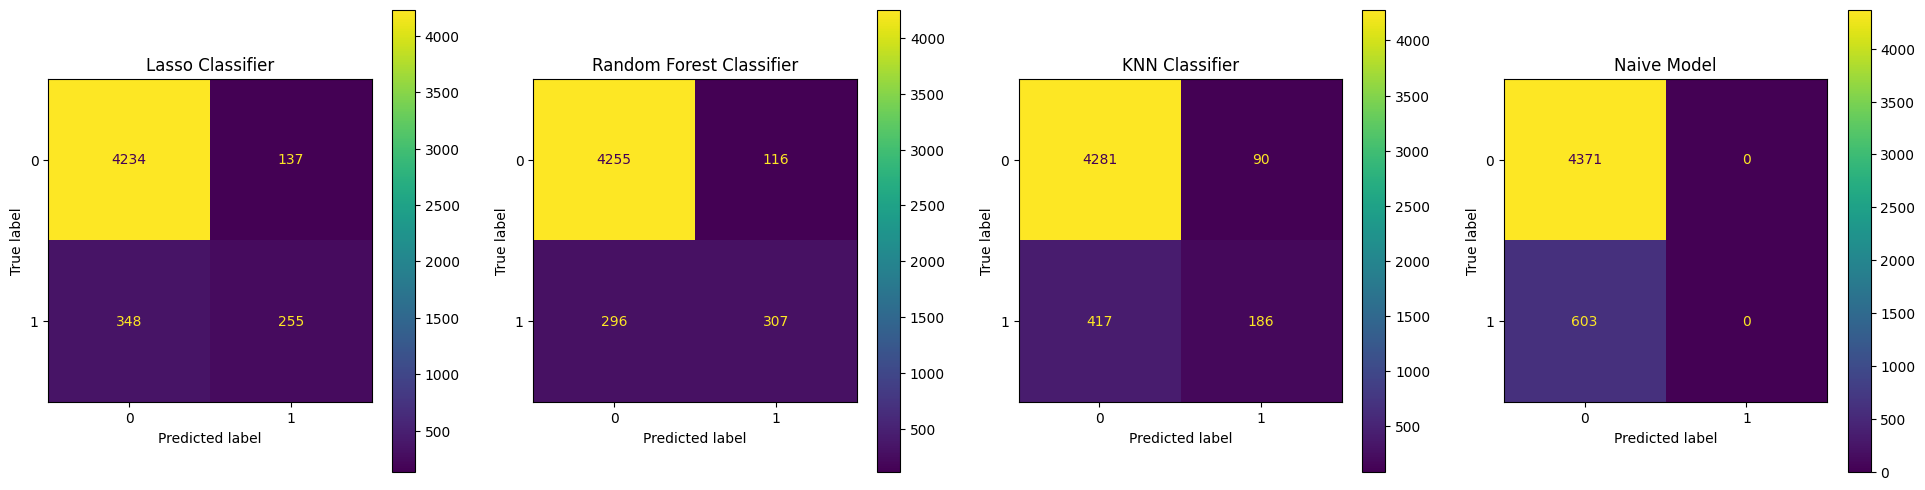

In [760]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

lasso_cm = confusion_matrix(y_te, lasso_predictions)
rf_cm = confusion_matrix(y_te, random_forest_predictions)
knn_cm = confusion_matrix(y_te, knn_predictions)
naive_cm = confusion_matrix(y_te, naive_predictions)


fig, ax = plt.subplots(1, 4, figsize=(24, 6))  # Increase subplot size for 4 models

ConfusionMatrixDisplay(lasso_cm).plot(ax=ax[0], cmap='viridis')
ax[0].set_title('Lasso Classifier')

ConfusionMatrixDisplay(rf_cm).plot(ax=ax[1], cmap='viridis')
ax[1].set_title('Random Forest Classifier')

ConfusionMatrixDisplay(knn_cm).plot(ax=ax[2], cmap='viridis')
ax[2].set_title('KNN Classifier')

ConfusionMatrixDisplay(naive_cm).plot(ax=ax[3], cmap='viridis')
ax[3].set_title('Naive Model')

plt.show()



From the confusion matrices we can compare the model in more detail. To me the more important metric is being able to correctly classify the acceptance of an offer, as opposed to correctly indentifying a decline. At the end of the day we will probably call everyone in the book. But we really want to prioritize those we know we should be able to make a sale. For that reason I would rate the Random Forest Classifier as the best model for this problem as it has indentified the most correct true labels of all the models and the model construction and performance was the best and made the most sense to me. Notice that the NB model as indicated earlier is fairly accurate to the imbalance but has no ability to predict a sale - in that sense it is not of much use. 

In [761]:
lasso_probs = lasso_reg.predict_proba(x_te_trans)[:, 1] 
rf_probs = random_forest.predict_proba(x_te)[:, 1]
knn_probs = tree_red_knn.predict_proba(tree_import_test)[:, 1]

naive_probs = [0 for _ in range(len(y_te))]

In [762]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

lasso_fpr, lasso_tpr, _ = roc_curve(y_te, lasso_probs)
lasso_auc = auc(lasso_fpr, lasso_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_te, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_te, knn_probs)
knn_auc = auc(knn_fpr, knn_tpr)

naive_fpr, naive_tpr, _ = roc_curve(y_te, naive_probs)
naive_auc = auc(naive_fpr, naive_tpr)


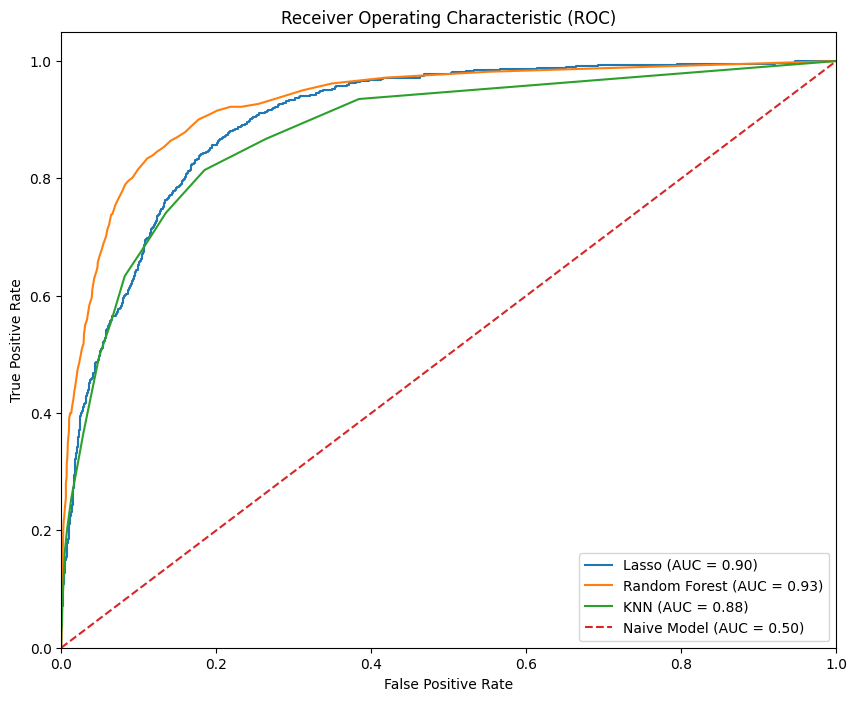

In [763]:
plt.figure(figsize=(10, 8))
plt.plot(lasso_fpr, lasso_tpr, label=f'Lasso (AUC = {lasso_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})')
plt.plot(naive_fpr, naive_tpr, label=f'Naive Model (AUC = {naive_auc:.2f})', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Looking at the ROC curves we can see once again that random forest model performs the best with the most area under the curve followed by logisic regression and then knn. 

#### **Conclusion**

In summary, the overall objectives of this study were met and I learned a ton throughout the process. We can clearly see that variables such as the duration of the phone call, whether we have previously contacted the client, if the last campaign was a success, their age, balance, and others do seem to be important indicators for predicting if a client will accept a term deposit or not. In the end, the Random Forest performed the best out of all the models fitted and evaluated. We performed a thorough analysis of descriptive statistics and model selection. The findings here could definitely impact how we make decisions about how to approach clients in a campaign like this and try to forecast the success of the project. Especially when combined with other data that would be available to us. I am very grateful to have taken this class and am slightly sad I ran out of time as I think a neural net may yet be the best model for this problem. I look forward to building on this foundation and continuing the machine learning journey!

#### References:
Moro, S., Raul M S Laureano, & Cortez, P. (n.d.). USING DATA MINING FOR BANK DIRECT MARKETING: AN APPLICATION OF THE CRISP-DM METHODOLOGY. http://repositorium.sdum.uminho.pt/bitstream/1822/14838/1/MoroCortezLaureano_DMApproach4DirectMKT.pdf

‌